# Gender Distribution of National Park Service Employees

Import libraries

In [247]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

from model import Classifier
import constants
import helpers

import pickle

Load the dataset and investigate the content

In [248]:
df = pd.read_csv('data/FOIA-Employee-List-9-15-2017.csv')
df.head()

,Dept,Bur Or Ofc,Org Abrev1,Org Desc,Name Whole,Position Title Opm,Date Entered On Duty Bureau,Duty Station City Desc,Duty Station State
0,IN,10,WRST,WRANGELL-ST ELIAS NTL PK&PRESV,"ABRAHAM, AMANDA D",BIOLOGICAL SCIENCE TECH (FISHERIES),05/28/17,"SLANA,ALASKA",AK
1,IN,10,WRST,WRANGELL-ST ELIAS NTL PK&PRESV,"ABRAHAM, JAMES L",MAINTENANCE WORKER,04/20/14,"SLANA,ALASKA",AK
2,IN,10,SITK,SITKA NATL HISTORICAL PARK,"ACKERMAN, KYLE T",PARK RANGER (INTERPRETATION),04/16/17,"SITKA,ALASKA",AK
3,IN,10,DENA,"SUPT, PLANNING, ADMIN, DENA","ADAMS, DAWN B.",ENVIRONMENTAL PROTECTION SPECIALIST,NaN,"DENALI PARK,ALASKA",AK
4,IN,10,DENA,"MAINTENANCE, DENA","ADEY, ERIK T",ADMINISTRATIVE SUPPORT ASSISTANT (OA),03/11/12,"DENALI PARK,ALASKA",AK


Only keep the `Name Whole` columns because that's all we need

In [249]:
name_df = df[['Name Whole']]
name_df.head()

,Name Whole
0,"ABRAHAM, AMANDA D"
1,"ABRAHAM, JAMES L"
2,"ACKERMAN, KYLE T"
3,"ADAMS, DAWN B."
4,"ADEY, ERIK T"


See how many names there are

In [250]:
name_df.shape

(23257, 1)

See if there are duplicates

In [251]:
names = name_df['Name Whole']
name_df[names.isin(names[names.duplicated()])]

,Name Whole
953,NaN
954,Name Whole
1170,NaN
1171,Name Whole
1260,NaN
1261,Name Whole
1282,"ADAMS, CHRISTOPHER J"
1283,"ADAMS, CHRISTOPHER J"
1589,"BEGAY, RAMONA"
1590,"BEGAY, RAMONA"


We only have to remove `NaN` and `Name Whole` values since the rest of the duplicates correspond to different employees in different departments like below

In [252]:
df[df['Name Whole'] == 'RUSSO, MICHAEL ANTHONY']

,Dept,Bur Or Ofc,Org Abrev1,Org Desc,Name Whole,Position Title Opm,Date Entered On Duty Bureau,Duty Station City Desc,Duty Station State
14270,IN,10,USPP,DC EAST-DISTRICT 4,"RUSSO, MICHAEL ANTHONY",PRIVATE,01/31/10,"WASHINGTON,DC",DC
21380,IN,10,SEAC,SE ARCHEOLOGICAL CENTER,"RUSSO, MICHAEL ANTHONY",ARCHEOLOGIST,NaN,"TALLAHASSEE,FLORIDA",FL


In [253]:
name_df = name_df.dropna(axis=0, how='all')
name_df = name_df[name_df['Name Whole'] != 'Name Whole']

Ensure all the undesired rows are removed

In [254]:
names = name_df['Name Whole']
name_df[names.isin(names[names.duplicated()])]

,Name Whole
1282,"ADAMS, CHRISTOPHER J"
1283,"ADAMS, CHRISTOPHER J"
1589,"BEGAY, RAMONA"
1590,"BEGAY, RAMONA"
1847,"BROWN, WILLIAM J."
2539,"EBERHARDY, ED R"
2540,"EBERHARDY, ED R"
6887,"CARROLL, MARK S"
6888,"CARROLL, MARK S"
7198,"FERGUSON, GARY L."


Convert name column into list

In [255]:
names = list(name_df['Name Whole'])

Investigate how the names are formatted

In [256]:
names[:15]

['ABRAHAM, AMANDA D',
 'ABRAHAM, JAMES L',
 'ACKERMAN, KYLE T',
 'ADAMS, DAWN B.',
 'ADEY, ERIK T',
 'ADKISSON, KENNETH L.',
 'ADLESPERGER, KENT L',
 'ADRIAN, GEOFFREY M L',
 'AIUPPA, ANTHONY A',
 'AIUPPA, EMILY J',
 'ALDEN, SHARON C',
 'ALEXANDER SHELKO, CHERILYN A D',
 'ALEXANDER, DAVID C',
 'ALEXIA, MICHAEL J',
 'ALEXIE, GEORGE E']

Extract the first names

In [257]:
first_names = []

for name in names:
    name = str(name).lower()
    name = name.replace('-', '')
    name = name.replace("'", '')
    name = name.split(',')[1].strip()
    name = name.split(' ')[0]
    
    first_names.append(name)

first_names[:15]

['amanda',
 'james',
 'kyle',
 'dawn',
 'erik',
 'kenneth',
 'kent',
 'geoffrey',
 'anthony',
 'emily',
 'sharon',
 'cherilyn',
 'david',
 'michael',
 'george']

Load vocab_to_int map

In [258]:
with open(constants.VOCAB_TO_INT_MAP_PATH, 'rb') as handle:
    vocab_to_int_map = pickle.load(handle)
    
vocab_to_int_map

{'a': 1,
 'e': 2,
 'n': 3,
 'i': 4,
 'r': 5,
 'l': 6,
 's': 7,
 'h': 8,
 'y': 9,
 'o': 10,
 't': 11,
 'd': 12,
 'm': 13,
 'k': 14,
 'c': 15,
 'u': 16,
 'j': 17,
 'b': 18,
 'v': 19,
 'g': 20,
 'z': 21,
 'w': 22,
 'p': 23,
 'f': 24,
 'q': 25,
 'x': 26}

Load model

In [259]:
checkpoint = torch.load(constants.MODEL_PATH)
sequence_length = checkpoint['sequence_length']
num_layers = checkpoint['num_layers']
vocab_size = checkpoint['vocab_size']
hidden_dim = checkpoint['hidden_dim']
output_size = checkpoint['output_size']
model_state_dict = checkpoint['model_state_dict']

classifier = Classifier(sequence_length, num_layers, vocab_size, hidden_dim, output_size)
classifier.load_state_dict(model_state_dict)

In [260]:
print(classifier)

Classifier(
  (lstm): LSTM(27, 128, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)


Check if we are training on a GPU or CPU

In [261]:
is_training_on_gpu = torch.cuda.is_available()

if is_training_on_gpu:
    print('Training on GPU')
    classifier.cuda()
else:
    print('Training on CPU')
    classifier.cpu()

Training on GPU


Test if the model works

In [262]:
test_name = 'Alesandro'
print('{} is {}'.format(test_name, helpers.infer_gender_from_name(test_name, 
                                                                  sequence_length, 
                                                                  vocab_to_int_map, 
                                                                  classifier, 
                                                                  is_training_on_gpu)))

Alesandro is male


In [263]:
genders = []
skipped_names = []

for name in first_names:
    # skip names with abbreviation
    if '.' in name:
        skipped_names.append(name)
        continue
    
    gender = helpers.infer_gender_from_name(name,
                                            sequence_length,
                                            vocab_to_int_map,
                                            classifier,
                                            is_training_on_gpu)
    
    genders.append(gender) 

See what names are skipped

In [264]:
skipped_names

['r.',
 'j.',
 'a.',
 'l.',
 'j.',
 'h.',
 'h.',
 'k.',
 'h.',
 'r.',
 's.',
 'r.',
 'w.',
 'm.',
 'j.',
 'e.',
 'h.',
 'g.',
 'f.',
 'c.',
 'w.']

See the distribution of genders

In [265]:
print('Total number of employees: {}'.format(len(genders)))
print('Total number of males: {}'.format(genders.count('male')))
print('Total number of females: {}'.format(genders.count('female')))

Total number of employees: 23216
Total number of males: 14541
Total number of females: 8675


([<matplotlib.patches.Wedge at 0x7f1f87a73358>,
 [Text(-0.4252111523424957, 1.0144927185167802, 'Male'),
  Text(0.42521105735882997, -1.0144927583279173, 'Female')],
 [Text(-0.23193335582317942, 0.5533596646455164, '63%'),
  Text(0.23193330401390722, -0.5533596863606821, '37%')])

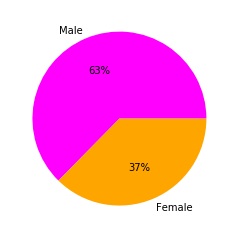

In [266]:
labels = ['Male', 'Female']
sizes = [genders.count('male'), genders.count('female')]
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors=['magenta', 'orange'])